In [1]:
import numpy as np
import xarray as xr
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz, FK5
import n_const.constants as n2const
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
start_time = np.datetime64("2020-03-20T00:00:00")
delta = 30  # seconds
dt = np.timedelta64(delta, "s")
data_num = int(np.timedelta64(1, "D") / dt)
t = [start_time + i * dt for i in range(data_num)]

dec_list = np.linspace(-90, 68, 100)
dec_list = np.broadcast_to(dec_list, (len(t), len(dec_list))) * u.deg
t = np.atleast_2d(t).T

coords = (
    SkyCoord(ra="0h", dec=dec_list, frame=FK5, obstime=t, location=n2const.LOC_NANTEN2).transform_to(AltAz)
)

altaz_coordinate = {"tracking": xr.DataArray(
    np.array([coords.az.value, coords.alt.value]),
    dims=["direction", "t", "dec"]
)}
coords = {
    "direction": ["az", "el"],
    "dec": np.unique(dec_list, axis=0)[0],
    "t": t.T[0]
}
altaz_coordinate.update(coords)

data = xr.Dataset(altaz_coordinate)

[None, Text(0.5, 0, 't [mm-dd hh]'), Text(0, 0.5, 'Dec. [deg]')]

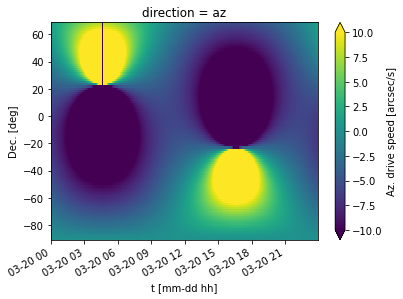

In [3]:
az_speed = data.tracking.sel(direction="az").differentiate("t") * 3600e9
el = data.tracking.sel(direction="el")

fig, ax = plt.subplots(1, 1)
az_speed.plot(
    vmax=10, vmin=-10,
    ax=ax, x="t",
    zorder=-1,
    cbar_kwargs={"label": "Az. drive speed [arcsec/s]"}
)
# ax.set_rasterization_zorder(0)
ax.set(rasterization_zorder=0, xlabel="t [mm-dd hh]", ylabel="Dec. [deg]")

[Text(0.65, 0.8, '30'),
 Text(0.65, 0.7050000000000001, '45'),
 Text(0.65, 0.6100000000000001, '60'),
 Text(0.65, 0.515, '75')]

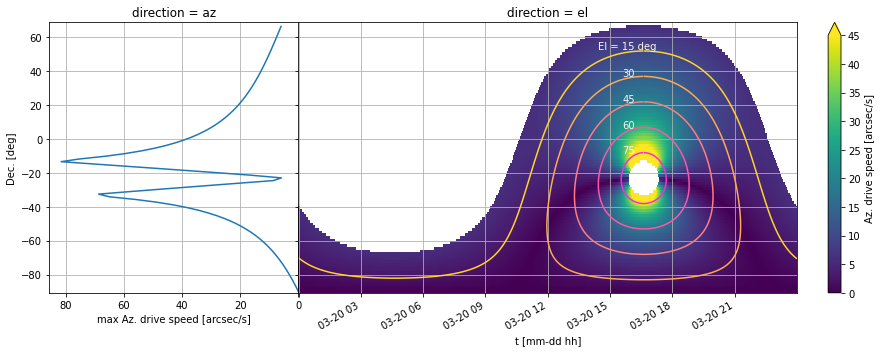

In [4]:
fig = plt.figure(figsize=(13, 5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 2.5], wspace=0)
axes = [fig.add_subplot(spec) for spec in gs]

# plot left graph
(
    abs(az_speed)
    .where((el < 80) & (el > 0) & (az_speed < 1000))
    .max("t")
    .plot(y="dec", ax=axes[0], xincrease=False)
)
axes[0].set(ylabel="Dec. [deg]", xlabel="max Az. drive speed [arcsec/s]", xlim=(None, 0))
axes[0].grid()

# plot right map
(
    abs(az_speed)
    .where((el < 80) & (el > 0) & (az_speed < 1000))
    .plot(x="t", ax=axes[1], zorder=-1, vmax=45, vmin=0, cbar_kwargs={"label": "Az. drive speed [arcsec/s]"})
)
# plot right contour
(
    el
    .where((el < 80) & (el > 0) & (az_speed < 1000))
    .plot.contour(x="t", cmap="spring_r")
)
axes[1].set(rasterization_zorder=0, xlabel="t [mm-dd hh]", ylabel="")
axes[1].tick_params(labelleft=False)
axes[1].grid()

# align the 2 axes
axes[0].sharey(axes[1])
plt.tight_layout()

# remove overlapping tick-label
axes[1].set_xticks(axes[1].get_xticks())
labels=axes[1].get_xticklabels()
labels[0] = ""
axes[1].set_xticklabels(labels)

# annotate contour levels
axes[1].text(0.6, 0.9, "El = 15 deg", c=(1,0.95,0.95), transform=axes[1].transAxes)
[
    axes[1].text(
        0.65, 0.8 - 0.095 * i,
        15 * (i + 2),
        c=(1,0.95,0.95),
        transform=axes[1].transAxes
    ) for i in range(4)
]

# plt.savefig("./tracking_speed.pdf", dpi=400)